# Readme

I just realised after checking this script thoroughly, it doesn't implement the same algorithm with the flow matching from the ppt. Because in this first script,  it does not implement the training process. For example, there is no model of u_(θ ), no loss calculation and optimizer/ gradient step. Because it only draws samples and interpolates. It also does not implement the exact sampling like in the ppt. It uses simple straight distance with a smooth step for the animation, but no real Euler stepping.

In [4]:
# Generates and saves a GIF: particles flow from a 2-D Gaussian into a checkerboard pattern.
# Ready to run in Colab too.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# ----------------------
# Config (tweak freely)
# ----------------------
N_PARTICLES = 1000      # number of particles
SIGMA = 1.2            # std for initial 2-D Gaussian
BOARD_HALF_EXTENT = 4  # plot shows [-L, L] x [-L, L]
SQUARE_SIZE = 1.0      # checkerboard square size
N_FRAMES = 70          # frames in GIF
FPS = 20               # frames per second for GIF
OUT_PATH = "/tmp/checker_flow.gif"

# ----------------------
# Build checkerboard
# ----------------------
L = BOARD_HALF_EXTENT
nx = ny = 400  # resolution for background image
x = np.linspace(-L, L, nx)
y = np.linspace(-L, L, ny)
X, Y = np.meshgrid(x, y)
# Checkerboard pattern: parity of the integer square indices
board = ((np.floor(X / SQUARE_SIZE) + np.floor(Y / SQUARE_SIZE)) % 2)

# ----------------------
# Initial particle positions (2-D Gaussian)
# ----------------------
rng = np.random.default_rng(42)
init_pos = rng.normal(loc=0.0, scale=SIGMA, size=(N_PARTICLES, 2))

# ----------------------
# Target positions: pick a random point inside random BLACK squares
# We define "black" squares as those where (i + j) % 2 == 0
# ----------------------
i_min = int(np.floor(-L / SQUARE_SIZE))
i_max = int(np.ceil( L / SQUARE_SIZE)) - 1
j_min = int(np.floor(-L / SQUARE_SIZE))
j_max = int(np.ceil( L / SQUARE_SIZE)) - 1

black_cells = [(i, j) for i in range(i_min, i_max + 1)
                         for j in range(j_min, j_max + 1)
                         if ((i + j) % 2 == 0)]
# Randomly assign a black cell to each particle, then a random point inside that cell
idx = rng.integers(low=0, high=len(black_cells), size=N_PARTICLES)
chosen = np.array([black_cells[k] for k in idx])

u = rng.random(size=N_PARTICLES)
v = rng.random(size=N_PARTICLES)
# Convert cell index to coordinates; square spans [i*s, (i+1)*s) in x and same for y
targets = np.empty_like(init_pos)
targets[:, 0] = (chosen[:, 0] + u) * SQUARE_SIZE
targets[:, 1] = (chosen[:, 1] + v) * SQUARE_SIZE

# ----------------------
# Easing for smooth motion: cubic smoothstep 3t^2 - 2t^3
# ----------------------
def ease(t):
    return 3*t*t - 2*t*t*t

# ----------------------
# Setup figure
# ----------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-L, L)
ax.set_ylim(-L, L)
ax.set_aspect('equal')
ax.set_xticks([]); ax.set_yticks([])
# Background checkerboard
#ax.imshow(board, extent=[-L, L, -L, L], origin='lower', interpolation='nearest')
# Particles
sc = ax.scatter(init_pos[:, 0], init_pos[:, 1], s=10)

# ----------------------
# Animation function
# ----------------------
def update(frame):
    t = frame / (N_FRAMES - 1)
    a = ease(t)
    pos = (1 - a) * init_pos + a * targets
    sc.set_offsets(pos)
    return (sc,)

anim = FuncAnimation(fig, update, frames=N_FRAMES, blit=True)
writer = PillowWriter(fps=FPS)
anim.save(OUT_PATH, writer=writer, dpi=150)

plt.close(fig)

OUT_PATH

'/tmp/checker_flow.gif'

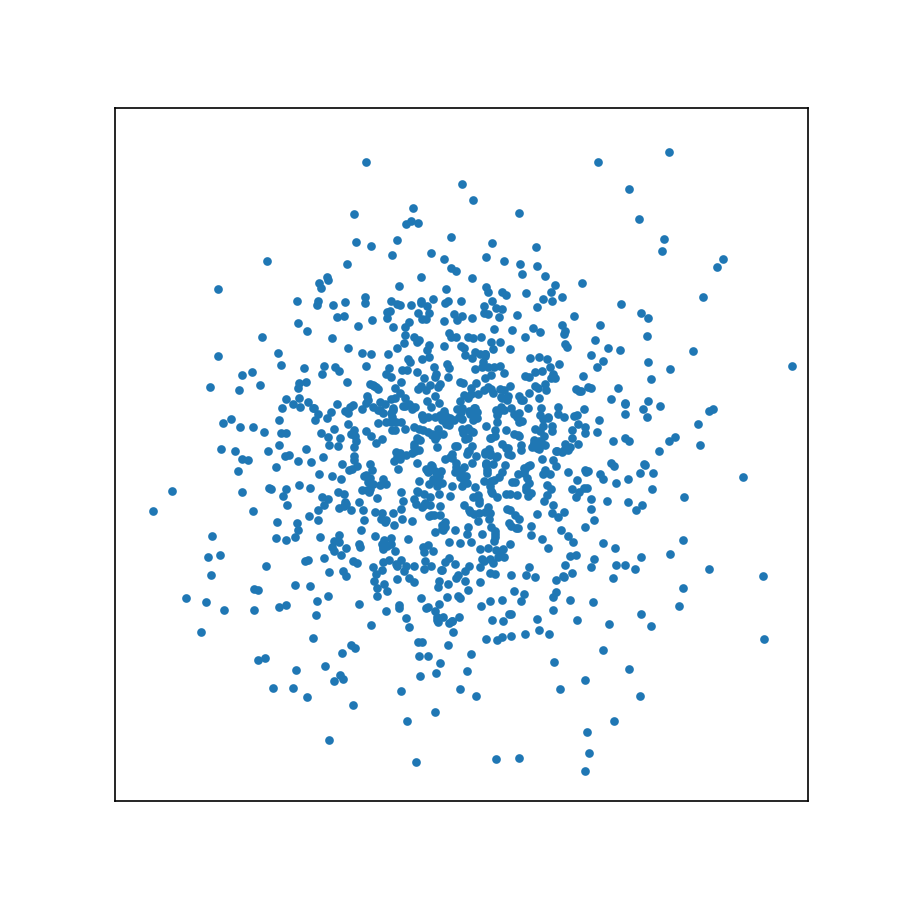

In [5]:
import IPython.display as ipd

ipd.Image(filename=OUT_PATH)

In [6]:
from google.colab import files

files.download(OUT_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Readme 2

This version trains a tiny vector-field 𝑢𝜃(𝑥𝑡,𝑡) by flow matching (straight transport) and then samples with Euler steps to make the GIF.

Training loop follows the PDF: draw 𝑥1⁣∼𝑝1 (checkerboard), 𝑥0⁣∼𝑁(0,𝐼), 𝑡∼𝑈[0,1], form 𝑥𝑡=(1−𝑡)𝑥0+𝑡𝑥1, target velocity 𝑣⋆=𝑥1−𝑥0, minimize ∥𝑢𝜃(𝑥𝑡,𝑡)−𝑣⋆∥2∥, update 𝜃θ.


Sampler follows the PDF: Euler integrate 𝑥𝑡+Δ𝑡=𝑥𝑡+𝑢𝜃(𝑥𝑡,𝑡) Δ𝑡 from 𝑥0 ⁣∼𝑁(0,𝐼) to 𝑡=1. Straight-transport reference 𝑥𝑡=(1−𝑡)𝑥0+𝑡𝑥1 for how the supervision.

In [14]:
# Flow Matching (straight transport) on a 2-D checkerboard
# - TRAIN: learn u_theta(x_t, t) ≈ (x1 - x0)
# - SAMPLE: Euler integrate x_{t+dt} = x_t + u_theta(x_t,t) * dt
# Produces a GIF of particles flowing from N(0, I) into the checkerboard pattern.

import math, os, io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

import torch
import torch.nn as nn
import torch.nn.functional as F

# -----------------------
# Config
# -----------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data (checkerboard + Gaussian)
BOARD_HALF_EXTENT = 4.0     # domain ~ [-L, L]^2
SQUARE_SIZE = 1.0
GAUSS_SIGMA = 1.2           # p0 = N(0, sigma^2 I)
# Training
BATCH_SIZE = 4096
STEPS = 5000                # increase for better quality (e.g., 5000+ on CPU/GPU)
LR = 2e-3
PRINT_EVERY = 200
# Sampler / GIF
N_PARTICLES = 800
N_STEPS = 80                # Euler N (more = smoother)
FPS = 20
OUT_PATH = "flow_matching_checker.gif"
RNG = np.random.default_rng(42)
torch.manual_seed(42)

In [15]:
# -----------------------
# Utilities: checkerboard sampling
# -----------------------
def sample_checkerboard(n, L=BOARD_HALF_EXTENT, s=SQUARE_SIZE, rng=RNG):
    """
    Sample n points uniformly from the union of BLACK squares:
      cell (i,j) is black if (i + j) % 2 == 0
    """
    i_min = int(np.floor(-L / s)); i_max = int(np.ceil(L / s)) - 1
    j_min = int(np.floor(-L / s)); j_max = int(np.ceil(L / s)) - 1
    black = [(i, j) for i in range(i_min, i_max + 1)
                     for j in range(j_min, j_max + 1)
                     if ((i + j) % 2 == 0)]
    idx = rng.integers(0, len(black), size=n)
    cells = np.array([black[k] for k in idx])
    u = rng.random(size=n); v = rng.random(size=n)
    x = (cells[:, 0] + u) * s
    y = (cells[:, 1] + v) * s
    pts = np.stack([x, y], axis=1)
    return pts.astype(np.float32)

def sample_gaussian(n, sigma=GAUSS_SIGMA, rng=RNG):
    return rng.normal(0.0, sigma, size=(n, 2)).astype(np.float32)

def sample_training_batch(batch_size=BATCH_SIZE):
    # x1 ~ p_data (checkerboard), x0 ~ N(0, I), t ~ U[0,1]
    x1 = sample_checkerboard(batch_size)
    x0 = sample_gaussian(batch_size)
    t = RNG.random(size=(batch_size, 1)).astype(np.float32)
    xt = (1.0 - t) * x0 + t * x1             # straight-transport interpolation (supervision point)
    v_star = x1 - x0                         # straight-transport velocity (target)
    return (torch.from_numpy(xt),
            torch.from_numpy(t),
            torch.from_numpy(v_star))

In [16]:
# -----------------------
# Model: small MLP for u_theta(x_t, t) -> R^2
# Input dim = 3 (x_t.x, x_t.y, t), Output dim = 2 (velocity)
# -----------------------
class VF(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, 2),
        )
        # small init helps stability
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(m.bias)

    def forward(self, x_t, t):
        # x_t: (B,2), t: (B,1)
        inp = torch.cat([x_t, t], dim=-1)     # (B,3)
        return self.net(inp)                  # (B,2)

u_theta = VF(hidden=128).to(DEVICE)
opt = torch.optim.AdamW(u_theta.parameters(), lr=LR, weight_decay=1e-6)

In [17]:
# -----------------------
# Training loop (Flow Matching: straight transport)
#   Minimize || u_theta(x_t, t) - (x1 - x0) ||^2
# -----------------------
u_theta.train()
for step in range(1, STEPS + 1):
    xt, t, v_star = sample_training_batch(BATCH_SIZE)
    xt = xt.to(DEVICE); t = t.to(DEVICE); v_star = v_star.to(DEVICE)

    v_pred = u_theta(xt, t)
    loss = F.mse_loss(v_pred, v_star)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    if step % PRINT_EVERY == 0 or step == 1:
        print(f"[{step:4d}/{STEPS}] loss={loss.item():.6f}")

# -----------------------
# Build checkerboard background for plotting
# -----------------------
def checker_image(L=BOARD_HALF_EXTENT, s=SQUARE_SIZE, res=400):
    x = np.linspace(-L, L, res)
    y = np.linspace(-L, L, res)
    X, Y = np.meshgrid(x, y)
    board = ((np.floor(X / s) + np.floor(Y / s)) % 2)
    return board

board_img = checker_image()

[   1/5000] loss=6.950219
[ 200/5000] loss=4.592523
[ 400/5000] loss=4.286212
[ 600/5000] loss=4.243306
[ 800/5000] loss=4.225237
[1000/5000] loss=4.236233
[1200/5000] loss=4.134700
[1400/5000] loss=4.113066
[1600/5000] loss=4.271777
[1800/5000] loss=4.259985
[2000/5000] loss=4.277280
[2200/5000] loss=4.192363
[2400/5000] loss=4.321182
[2600/5000] loss=4.246050
[2800/5000] loss=4.128606
[3000/5000] loss=4.220545
[3200/5000] loss=4.355756
[3400/5000] loss=4.280014
[3600/5000] loss=4.124249
[3800/5000] loss=4.322097
[4000/5000] loss=4.265061
[4200/5000] loss=4.292457
[4400/5000] loss=4.262861
[4600/5000] loss=4.304636
[4800/5000] loss=4.167876
[5000/5000] loss=4.290593


In [21]:
# -----------------------
# Sampling with Euler method (PDF)
#   x_{t+dt} = x_t + u_theta(x_t, t) * dt, t in [0,1]
# -----------------------
@torch.no_grad()
def euler_sample(n_particles=N_PARTICLES, n_steps=N_STEPS):
    u_theta.eval()
    x = torch.from_numpy(sample_gaussian(n_particles)).to(DEVICE)  # x0 ~ N(0, I)
    dt = 1.0 / n_steps
    traj = [x.detach().cpu().numpy()]
    for i in range(n_steps):
        t = torch.full((n_particles, 1), float(i) / n_steps, device=DEVICE)
        v = u_theta(x, t)             # predicted velocity
        x = x + v * dt                # Euler step
        traj.append(x.detach().cpu().numpy())
    return traj  # list of (N,2) arrays length n_steps+1

traj = euler_sample()

# -----------------------
# Make GIF
# -----------------------
fig, ax = plt.subplots(figsize=(6, 6))
L = BOARD_HALF_EXTENT
ax.set_xlim(-L, L); ax.set_ylim(-L, L); ax.set_aspect('equal')
ax.set_xticks([]); ax.set_yticks([])
#ax.imshow(board_img, extent=[-L, L, -L, L], origin='lower', interpolation='nearest')
sc = ax.scatter(traj[0][:,0], traj[0][:,1], s=10)

def update(frame):
    sc.set_offsets(traj[frame])
    return (sc,)

anim = FuncAnimation(fig, update, frames=len(traj), blit=True)
writer = PillowWriter(fps=FPS)
anim.save(OUT_PATH, writer=writer, dpi=150)
plt.close(fig)

print(f"Saved GIF to: {OUT_PATH}")

Saved GIF to: flow_matching_checker.gif


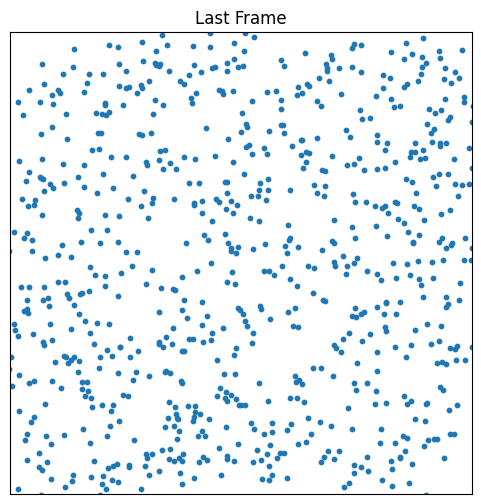

In [23]:
plt.figure(figsize=(6, 6))
#plt.imshow(board_img, extent=[-L, L, -L, L], origin='lower', interpolation='nearest')
plt.scatter(traj[-1][:, 0], traj[-1][:, 1], s=10)
plt.xlim(-L, L)
plt.ylim(-L, L)
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks([]); plt.yticks([])
plt.title("Last Frame")
plt.show()